<a href="https://colab.research.google.com/github/Kwanikaze/vpandas/blob/master/MRF_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

!pip install -i https://test.pypi.org/simple/ PPandas==0.0.1.7.1
!pip install python-intervals
!pip install geopandas
!pip install geovoronoi
import ppandas
from ppandas import PDataFrame

Looking in indexes: https://test.pypi.org/simple/


# Load Data and Create Sample Datasets

In [2]:
# Function to create two datasets from global df that are one-hot encoded
def OHE_sample(sample_df, features_to_OHE: list):
  for feature in features_to_OHE:
    feature_OHE = pd.get_dummies(prefix = feature,data= sample_df[feature])
    sample_df = pd.concat([sample_df,feature_OHE],axis=1)
  sample_df.drop(features_to_OHE,axis=1,inplace=True)
  print(sample_df)
  return sample_df

In [3]:
# Load global relation
df = pd.read_csv("data_8.csv")
print(df.shape)

#Create two datasets containing AB and BC
num_samples = 1000
sample1_df = df[['A','B']].sample(n=num_samples, random_state=2)
print(sample1_df.head())
sample2_df = df[['B','C']].sample(n=num_samples, random_state=3)
print(sample2_df.head())

# Make A,B,C inputs all 8 bits
#Does data need to respect Gaussian distribution?
#Could add noise so not exactly OHE: 0.01...0.9...0.01
sample1_OHE = OHE_sample(sample1_df,['A','B'])
sample2_OHE = OHE_sample(sample2_df,['B','C'])

# Could onvert pandas dataframes to list of lists of lists
# [ [[OHE A1],[OHE B1]], [[OHE A2],[OHE B2]], ...  ]

(5056, 3)
      A  B
4333  7  6
2638  6  4
2254  4  4
3116  5  5
3998  6  6
      B  C
4616  7  6
2276  4  6
3448  5  4
4064  6  5
1204  2  3
      A_0  A_1  A_2  A_3  A_4  A_5  A_6  ...  B_1  B_2  B_3  B_4  B_5  B_6  B_7
4333    0    0    0    0    0    0    0  ...    0    0    0    0    0    1    0
2638    0    0    0    0    0    0    1  ...    0    0    0    1    0    0    0
2254    0    0    0    0    1    0    0  ...    0    0    0    1    0    0    0
3116    0    0    0    0    0    1    0  ...    0    0    0    0    1    0    0
3998    0    0    0    0    0    0    1  ...    0    0    0    0    0    1    0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1857    0    1    0    0    0    0    0  ...    0    0    1    0    0    0    0
3813    0    0    0    0    0    1    0  ...    0    0    0    0    0    1    0
604     1    0    0    0    0    0    0  ...    1    0    0    0    0    0    0
621     1    0    0    0    0    0    0  ...    1    0    

# Global Relation Bayesian Network Ground Truth


 P(B|A=0) 
 Ground Truth


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


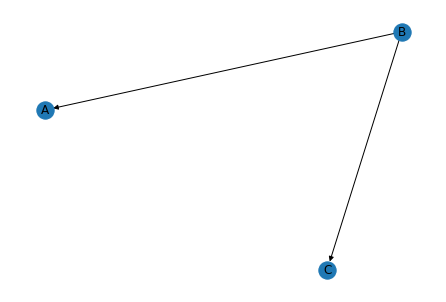

Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 297.28it/s]


 Global Relation Ground Truth
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2500 |
+------+----------+
| B(1) |   0.2500 |
+------+----------+
| B(2) |   0.2500 |
+------+----------+
| B(3) |   0.2500 |
+------+----------+
| B(4) |   0.0000 |
+------+----------+
| B(5) |   0.0000 |
+------+----------+
| B(6) |   0.0000 |
+------+----------+
| B(7) |   0.0000 |
+------+----------+

 P(A|B=0) 
 Ground Truth


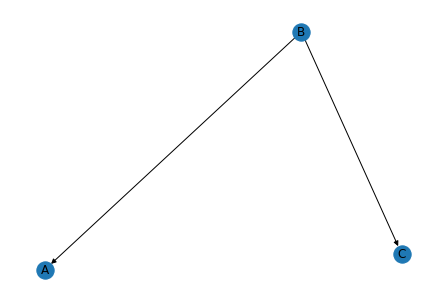

Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 629.68it/s]


 Global Relation Ground Truth
+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.2500 |
+------+----------+
| A(1) |   0.2500 |
+------+----------+
| A(2) |   0.2500 |
+------+----------+
| A(3) |   0.2500 |
+------+----------+
| A(4) |   0.0000 |
+------+----------+
| A(5) |   0.0000 |
+------+----------+
| A(6) |   0.0000 |
+------+----------+
| A(7) |   0.0000 |
+------+----------+


In [4]:
!pip install pgmpy==0.1.9
import pgmpy
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

def groundTruth(df,query_attribute,evidence):
    """
    Extracts ground truth from global relation
    """
    model = BayesianModel([('B', 'A'), ('B', 'C')])
    model.fit(df)
    nx.draw(model, with_labels=True)
    plt.show()
    print('\n Global Relation Ground Truth')
    #for var in model.nodes():
    #    print(model.get_cpds(var))
    inference = VariableElimination(model)
    
    #q = inference.query(variables=['A','B','C'])
    #joint_prob = q.values.flatten()
    #print(joint_prob)
    #print('\n P(A,B,C) \n Ground Truth')
    #print(q)
    q = inference.query(variables=[query_attribute], evidence=evidence)
    print(q)

print('\n P(B|A=0) \n Ground Truth')
groundTruth(df,query_attribute = 'B', evidence = {'A':0})

print('\n P(A|B=0) \n Ground Truth')
groundTruth(df,query_attribute = 'A', evidence = {'B':0})

# ppandas

In [5]:


def ppandas_query(sample1_df,sample2_df,num_samples,query_attribute,evidence):
    pd1 = PDataFrame(['B'],sample1_df)
    pd2 = PDataFrame(['B'],sample2_df)
    pd_join = pd1.pjoin(pd2)
    q = pd_join.query(['A','B','C'])
    #print("\n ppandas P(A,B,C) , n={} \n ".format(num_samples))
    #Re-arrange columns from CBA to ABC
    cols = q.columns.tolist()
    #print('the cols')
    #print(cols)
    #4th column rename to Probabability(A,B,C)
    q = q.rename(columns={q.columns[3]:'Probability(A,B,C)'})
    #Reorder columns
    q = q[['A','B','C','Probability(A,B,C)']]
    q= q.sort_values(by=['A','B','C'])
    #print(q)
    #Sort rows in dataframe by descending order
    joint_prob_ppandas = q
    #joint_prob_ppandas = q.values.flatten()[3::4] #start at 4th value(index 3), stepsize is 4
    #print('joint')
    #print(joint_prob_ppandas)
    print("\n ppandas P({}|{}) , n={} \n ".format(query_attribute,evidence,num_samples))
    q1 = pd_join.query([query_attribute],evidence_vars=evidence)
    print(q1)
    q1 = pd_join.map_query([query_attribute],evidence_vars=evidence)
    query_C_result = -1
    for _,value in q1.items():
        query_C_result = value
    #pd_join.visualise()
    return joint_prob_ppandas,query_C_result


joint_prob_ppandas, ppandas_C = ppandas_query(sample1_df,sample2_df,num_samples,query_attribute='B',evidence={'A':0})
#print(ppandas_C)


 ppandas P(B|{'A': 0}) , n=1000 
 
     B  Probability(B)
0  0.0        0.290909
1  1.0        0.218182
2  2.0        0.236364
3  3.0        0.254545
4  4.0        0.000000
5  5.0        0.000000
6  6.0        0.000000
7  7.0        0.000000


# VAE-MRF Architecture

In [6]:
# VAE Parameters
num = 8 # digits from 0 to 7
latent_dims = 3 # Latent z_A,z_B,z_C all are all same dimension size
num_epochs = 1000
batch_size = 64
learning_rate = 1e-3
use_gpu = True
variational_beta = 0.00001 #tuned 0.00001

In [1]:
class VariationalAutoencoder_MRF(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1A = nn.Linear(num, latent_dims)
        self.fc_muA = nn.Linear(latent_dims, latent_dims)
        self.fc_logvarA = nn.Linear(latent_dims, latent_dims)
        self.fc_outA = nn.Linear(latent_dims,num)
        
        self.fc1B = nn.Linear(num, latent_dims)
        self.fc_muB = nn.Linear(latent_dims, latent_dims)
        self.fc_logvarB = nn.Linear(latent_dims, latent_dims)
        self.fc_outB = nn.Linear(latent_dims,num)

        #Covariance: Sigma_{AB} = Sigma_{BA}^T
        # Sigma_AB is the top right term
        #self.covarianceAB = nn.Parameter(torch.zeros(latent_dims,latent_dims),requires_grad=True)
        self.covarianceAB = torch.randn(size=(latent_dims,latent_dims))
        self.covarianceAB = torch.nn.Parameter(self.covarianceAB,requires_grad=True)
        #self.covarianceAB = torch.nn.Parameter(0.5* torch.exp(self.covarianceAB),requires_grad=True)
        #self.covarianceAB = nn.Parameter(torch.rand(size=(latent_dims,latent_dims), requires_grad=True))
        #print(self.covarianceAB)

    def reparameterize(self, mu, logvar): #mu.size() = batch_size, 3
        std = torch.exp(0.5*logvar) #batch_size,3 
        eps = torch.randn_like(std) #batch_size,3
        return mu + eps*std # batch_size,3


    # Conditional of Multivariate Gaussian: matrix cookbook 353 and 354
    def conditional(self, muA, logvarA, muB, logvarB, z, attribute):
        #Convert logvarA vector to diagonal matrix
        #log-space for numerical stability.
        logvarA = torch.exp(0.5*logvarA)
        logvarB = torch.exp(0.5*logvarB)
        covarianceA = torch.diag_embed(logvarA) #batch_size,3,3
        covarianceB = torch.diag_embed(logvarB)
        #self.covarianceAB = torch.nn.Parameter(0.5* torch.exp(self.covarianceAB),requires_grad=True)
        muA = muA.unsqueeze(2)
        muB = muB.unsqueeze(2)
        z = z.unsqueeze(2)
        if attribute == 'A':
          mu_cond = muA + torch.matmul(torch.matmul(self.covarianceAB, 
                                                    torch.inverse(covarianceB)),
                                   (z - muB)) # z is zB
          logvar_cond = covarianceA - torch.matmul(torch.matmul(self.covarianceAB, 
                                                      torch.inverse(covarianceB)),
                                             torch.transpose(self.covarianceAB,0,1))
          #logvar_cond = logvar_cond + 20*torch.eye(latent_dims) # regularization
        elif attribute == 'B':
          mu_cond = muB + torch.matmul(torch.matmul(torch.transpose(self.covarianceAB,0,1),
                                                    torch.inverse(covarianceA)), 
                                       (z - muA)) # z is zA
          logvar_cond = covarianceB - torch.matmul(torch.matmul(torch.transpose(self.covarianceAB,0,1), 
                                                              torch.inverse(covarianceA)),
                                                 self.covarianceAB)
          #logvar_cond = logvar_cond + 20*torch.eye(latent_dims)

        # METHOD1: re-parameterization trick
        eps = torch.randn_like(mu_cond) #64x3x1, 64x3x3 if use logvar_cond
        sample = mu_cond + torch.matmul(logvar_cond,eps) #64x3x1
        sample = sample.squeeze(2) #64x3

        #METHOD 2 - random sampling, can't backprop
        #mu_cond = mu_cond.squeeze(2)
        #distrib = MultivariateNormal(loc=mu_cond, covariance_matrix=logvar_cond)
        #sample = distrib.rsample() # 64x3
        
        return sample
        # logvar_cond is not a diagonal covariance matrix
        #VAE reparameterization trick with non-diagonal covariance?
        #https://stats.stackexchange.com/questions/388620/variational-autoencoder-and-covariance-matrix

    def encode(self, x, attribute):
        if attribute == 'A':
          h1 = torch.sigmoid(self.fc1A(x))
          return self.fc_muA(h1), self.fc_logvarA(h1)
        elif attribute == 'B':
          h1 = torch.sigmoid(self.fc1B(x))
          return self.fc_muB(h1), self.fc_logvarB(h1)
        print('ERROR')
        return -100

    def decode(self, z, attribute):
        if z.size()[0] == latent_dims: #resize from [3] to [1,3] if fed only a single sample
            z = z.view(1, latent_dims)
        softmax = nn.Softmax(dim=1)
        if attribute == 'A':
          reconA = softmax(self.fc_outA(z))
          return reconA
        elif attribute == 'B':
          reconB = softmax(self.fc_outB(z))
          return reconB
        print('ERROR')
        return -100
    
    def forward(self, xA, xB, attribute):
        muA, logvarA = self.encode(xA, attribute='A') #logvar is size [64,3]
        #print(muA.size())
        muB, logvarB = self.encode(xB, attribute='B')
        if attribute == 'A':
          zB = self.reparameterize(muB, logvarB)
          zA = self.conditional(muA, logvarA, muB, logvarB, zB, attribute)
          return self.decode(zA,attribute), muA, logvarA
        elif attribute == 'B':
          zA = self.reparameterize(muA, logvarA)
          zB = self.conditional(muA, logvarA, muB, logvarB, zA, attribute)
          return self.decode(zB,attribute), muB, logvarB
        print('ERROR')
        return -100

    def forward_single_attribute(self, x, attribute):
        mu, logvar = self.encode(x,attribute)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, attribute), mu, logvar

    def query_single_attribute(self, x_evidence, evidence_attribute):
        if evidence_attribute =='A':
          muA,logvarA = self.encode(x_evidence, evidence_attribute)
          muB = torch.zeros(muA.size()) #100x3
          logvarB = torch.ones(muA.size()) #100x3
          #logvarB = torch.zeros(muA.size())
          zA = self.reparameterize(muA, logvarA)
          zB = self.conditional(muA, logvarA, muB, logvarB, zA, attribute='B')
          return self.decode(zB,attribute='B')

def vae_loss(batch_recon, batch_targets, mu, logvar):
  criterion = nn.CrossEntropyLoss()
  CE = criterion(batch_recon, batch_targets)
  #print(CE)
  KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
  #print(KLd)
  return CE,variational_beta*KLd, CE + variational_beta*KLd

NameError: ignored

# Multivariate Normal
Koller Equation 7.3: \\
$P(z_A,z_B) = Normal
\left(\left( \begin{array}{r} \mu_A \\ \mu_B \end{array} \right), 
\left[ \begin{array}{r} \Sigma_{A} & \Sigma_{AB} \\ \Sigma_{BA} & \Sigma_{B} \end{array} \right] \right) $ 

which is equivalent to the Matrix Cookbook (353 and 354) https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf: \\
$P(z_A|z_B) = Normal_{z_A}(\hat{\mu}_A, \hat{\Sigma}_A)$ \\
where: \\
$\hat{\mu}_A = \mu_A + \Sigma_{AB} \Sigma_{B}^{-1}(z_B - \mu_B)$ \\
$\hat{\Sigma}_A = \Sigma_A - \Sigma_{AB} \Sigma_B^{-1} \Sigma_{AB}^T$ \\

$P(z_B|z_A) = Normal_{z_B}(\hat{\mu}_B, \hat{\Sigma}_B)$ \\
where: \\
$\hat{\mu}_B = \mu_B + \Sigma_{AB}^T \Sigma_{A}^{-1}(z_A - \mu_A)$ \\
$\hat{\Sigma}_B = \Sigma_B - \Sigma_{AB}^T \Sigma_A^{-1} \Sigma_{AB}$ \\


The output of the VAE encoders are assumed to be the mean and variance of the unary normal potentials in the MRF over the latent z's where:

•	Mean: $\mu_{A}$ and diagonal variance matrix: $\Sigma_{A}$ are the outputs of the A encoder \\
•	$\mu_{B}$,  $\Sigma_{B}$ are the outputs of the B encoder \\


The additional pairwise k-ary Normal potentials, which represent undirected graphical model structure between the latent A and latent B : \\
•	$\Sigma_{AB}$ = $\Sigma_{BA}^T$ 

If the latent space is dimension 3, each $\mu \in \mathcal{R}^{1 \times 3}$ and each $\Sigma \in \mathcal{R}^{3 \times 3}$.

# Training the VAE-MRF
In each epoch, break the training data into batches of OHE input $x_A$ and $x_B$:
- Feed in $x_A$ and $x_B$ to their respective encoders to:
  - obtain $\mu_A, \Sigma_A$ from encoder A
  - obtain $\mu_B, \Sigma_B$ from encoder B
- To reconstruct $x_A$:
  - Sample $z_B$ using $\mu_B, \Sigma_B$ (standard VAE reparameterization trick)
  - Then using $z_B$, sample $z_A$ from $P(z_A|z_B)$ using $\mu_A, \Sigma_A, \mu_B, \Sigma_B$ as well (modified VAE reparameterization trick)
  - Feed $z_A$ into the A decoder to obtain the reconstruction $\hat{x}_A$ for $x_A$

- To reconstruct $x_B$:
  - Sample $z_A$ using $\mu_A, \Sigma_A$ (standard VAE reparameterization trick)
  - Then using $z_A$, sample $z_B$ from $P(z_B|z_A)$ using $\mu_A, \Sigma_A, \mu_B, \Sigma_B$ as well (modified VAE reparameterization trick)
  - Feed $z_B$ into the B decoder to obtain the reconstruction $\hat{x}_B$ for $x_B$

- Sum the losses (reconstruction error and KL-divergence) from both A and B  and backpropagate once per batch

Repeat for each batch. \\

Note that there is a different $\mu_A$, $\Sigma_A$ for each $x_A$ and a different $\mu_B$, $\Sigma_B$ for each $x_B$, while there is only one $\Sigma_{AB}$ to be shared. 
# Querying the VAE-MRF
Once  the VAE-MRF is trained, to query P(B|A=0=(1,0,0,0,0,0,0,0))
- Feed $x_A$ into the A encoder to obtain $\mu_A, \Sigma_A$ and sample to obtain z_A
- Since no input $x_B$ to the B encoder, I assume $\mu_B, \Sigma_B$ come from the prior P(z) = Normal (0, Identity)
- Using $\mu_A, \Sigma_A, z_A, \mu_B, \Sigma_B$, sample $z_B$ 
- Feed $z_B$ into the B decoder to obtain $\hat{x}_B$ \\

Repeat, feeding in evidence $x_A$ multiple times to the VAE-MRF to obtain a probability distribution $P(\hat{x}_B|x_A)$
# Notes

A symmetric matrix is positive definite if:

- all the diagonal entries are positive, and
- each diagonal entry is greater than the sum of the absolute values of all other entries in the corresponding row/column.


In [8]:
def trainVAE(VAE):
  VAE.train() #set model mode to train
  xA = sample1_OHE.filter(like='A', axis=1).values
  xB = sample1_OHE.filter(like='B', axis=1).values
  #print(xA.shape)

  #sample2_OHE when do BC plate
  
  indsA = list(range(xA.shape[0]))
  indsB = list(range(xB.shape[0]))
  N = num_samples # 1000
  freq = num_epochs // 10 # floor division

  loss_hist = []
  xA = Variable(torch.from_numpy(xA))
  xB = Variable(torch.from_numpy(xB))
  
  for epoch in range(num_epochs):
      #print('epoch' + str(epoch))
      indsA = np.random.permutation(indsA)
      xA = xA[indsA]
      xA = xA.to(device)
      indsB = np.random.permutation(indsB)
      xB = xB[indsB]
      xB = xB.to(device)
      
      loss = 0
      CE = 0
      KLd = 0
      num_batches = N / batch_size
      for b in range(0, N, batch_size):
          #get the mini-batch
          x_batchA = xA[b: b+batch_size]
          x_batchB = xB[b: b+batch_size]
          
          #feed forward
          batch_reconA,latent_muA,latent_logvarA = VAE.forward(x_batchA.float(),x_batchB.float(),attribute='A')
          batch_reconB,latent_muB,latent_logvarB = VAE.forward(x_batchA.float(),x_batchB.float(),attribute='B')

          # Error
          #Convert x_batchA and x_batchB from OHE vectors to single scalar
          # max returns index location of max value in each sample of batch 
          _, xA_batch_targets = x_batchA.max(dim=1)
          _, xB_batch_targets = x_batchB.max(dim=1)
          train_CE_A, train_KLd_A, train_loss_A = vae_loss(batch_reconA, xA_batch_targets, latent_muA, latent_logvarA)
          train_CE_B, train_KLd_B, train_loss_B = vae_loss(batch_reconB, xB_batch_targets, latent_muB, latent_logvarB)
          loss += train_loss_A.item() / N # update epoch loss
          loss += train_loss_B.item() / N
          CE += train_CE_A.item() / N
          CE += train_CE_B.item() / N 
          KLd += train_KLd_A.item() / N
          KLd += train_KLd_B.item() / N

          #Backprop the error, compute the gradient
          optimizer.zero_grad()
          train_loss = train_loss_A + train_loss_B
          train_loss.backward()
          
          #update parameters based on gradient
          optimizer.step()
          
      #Record loss per epoch        
      loss_hist.append(loss)
      
      if epoch % freq == 0:
          #print(VAE.covarianceAB)
          print('')
          print("Epoch %d/%d\t CE: %.5f, KLd: %.5f, Train loss=%.5f" % (epoch + 1, num_epochs,CE,KLd, loss), end='\t', flush=True)

          #Test with all training data
          VAE.eval()
          train_reconA, train_muA, train_logvarA = VAE.forward(xA.float(),xB.float(), attribute='A')
          train_reconB, train_muB, train_logvarB = VAE.forward(xA.float(),xB.float(), attribute='B')
          _, xA_targets = xA.max(dim=1)
          _, xB_targets = xB.max(dim=1)
          CE_A,KLd_A,test_loss_A = vae_loss(train_reconA, xA_targets, train_muA, train_logvarA)
          CE_B,KLd_B,test_loss_B = vae_loss(train_reconB, xB_targets, train_muB, train_logvarB)

          CE = CE_A + CE_B
          Kld = KLd_A + KLd_B
          test_loss = test_loss_A + test_loss_B
          print("\t CE: {:.5f}, KLd: {:.5f}, Test loss: {:.5f}".format(CE,KLd,test_loss.item()), end='')
      
  print("\nTraining finished!")
  #print(loss_hist)

In [9]:
# Focus on just AB Plate for now
#  use gpu if available
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
VAE = VariationalAutoencoder_MRF()
VAE = VAE.to(device)
num_params = sum(p.numel() for p in VAE.parameters() if p.requires_grad)

#for param in VAE.parameters():
#    print(type(param.data), param.size())
#print(list(VAE.parameters()))
print(VAE.parameters)
print("Number of parameters: %d" % num_params) #8*3 + 3 = 27, 3*8 + 8 = 32 3*3+3 = 12 *2 = 24, 27+32+24=83

# optimizer object
optimizer = torch.optim.Adam(params = VAE.parameters(), lr = learning_rate)

trainVAE(VAE)

<bound method Module.parameters of VariationalAutoencoder_MRF(
  (fc1A): Linear(in_features=8, out_features=3, bias=True)
  (fc_muA): Linear(in_features=3, out_features=3, bias=True)
  (fc_logvarA): Linear(in_features=3, out_features=3, bias=True)
  (fc_outA): Linear(in_features=3, out_features=8, bias=True)
  (fc1B): Linear(in_features=8, out_features=3, bias=True)
  (fc_muB): Linear(in_features=3, out_features=3, bias=True)
  (fc_logvarB): Linear(in_features=3, out_features=3, bias=True)
  (fc_outB): Linear(in_features=3, out_features=8, bias=True)
)>
Number of parameters: 175

Epoch 1/1000	 CE: 0.06726, KLd: 0.00001, Train loss=0.06727		 CE: 4.21200, KLd: 0.00001, Test loss: 4.21964
Epoch 101/1000	 CE: 0.05887, KLd: 0.00007, Train loss=0.05894		 CE: 3.66864, KLd: 0.00007, Test loss: 3.74037
Epoch 201/1000	 CE: 0.04676, KLd: 0.00021, Train loss=0.04697		 CE: 2.91975, KLd: 0.00021, Test loss: 3.12877
Epoch 301/1000	 CE: 0.04130, KLd: 0.00037, Train loss=0.04166		 CE: 2.57969, KLd: 0.0

It appears the model converges to a local minimum.

## Check encoder, decoders work on their own
- could also train encoder and decoders on their own?

In [10]:
x_test = np.eye(num)[np.arange(num)]                        # Test data (one-hot encoded)
x_test = Variable(torch.from_numpy(x_test))
x_test = x_test.to(device)

print("Print prediction results for A only:")
for x in x_test:
    print("\tInput: {} \t Output: {}".format(x.cpu().detach().numpy(), np.round(VAE.forward_single_attribute(x=x.float(), attribute='A')[0].cpu().detach().numpy(),decimals=2)))
print("Print prediction results for B only:")
for x in x_test:
    print("\tInput: {} \t Output: {}".format(x.cpu().detach().numpy(), np.round(VAE.forward_single_attribute(x=x.float(), attribute='B')[0].cpu().detach().numpy(),decimals=2)))

Print prediction results for A only:
	Input: [1. 0. 0. 0. 0. 0. 0. 0.] 	 Output: [[1. 0. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 1. 0. 0. 0. 0. 0. 0.] 	 Output: [[0. 1. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 1. 0. 0. 0. 0. 0.] 	 Output: [[0. 0. 1. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 1. 0. 0. 0. 0.] 	 Output: [[0. 0. 0. 1. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 1. 0. 0. 0.] 	 Output: [[0. 0. 0. 0. 1. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 0. 1. 0. 0.] 	 Output: [[0. 0. 0. 0. 0. 1. 0. 0.]]
	Input: [0. 0. 0. 0. 0. 0. 1. 0.] 	 Output: [[0. 0. 0. 0. 0. 0. 1. 0.]]
	Input: [0. 0. 0. 0. 0. 0. 0. 1.] 	 Output: [[0. 0. 0. 0. 0. 0. 0. 1.]]
Print prediction results for B only:
	Input: [1. 0. 0. 0. 0. 0. 0. 0.] 	 Output: [[1. 0. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 1. 0. 0. 0. 0. 0. 0.] 	 Output: [[0. 1. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 1. 0. 0. 0. 0. 0.] 	 Output: [[0. 0. 1. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 1. 0. 0. 0. 0.] 	 Output: [[0. 0. 0. 1. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 1. 0. 0. 0.] 	 Output: [[0. 0. 0. 0. 1. 0

# Query P(B|A=0)
Feed nothing into B encoder, muB is zero, logVarB is standard diagonal

In [11]:
xA_evidence = x_test[0] #Evidence is A=0
xA_evidence = xA_evidence.repeat(1000,1)
print('A evidence input, first 5 of 100 samples:')
print(xA_evidence[0:5]) #need to resize/ view for single sample, or make evidence a batch repeated

print('B query output:')
xB_query = VAE.query_single_attribute(x_evidence=xA_evidence.float(), evidence_attribute = 'A')
#print(np.round(xB_query[0:5].cpu().detach().numpy(),decimals=2))
print(xB_query.size())
#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))


#Taking max of each row in xB_query and counting times each element is max
print('xB_query count of when each column is max:')
_,indices_max =xB_query.max(dim=1) 
#print(indices_max.numpy())
unique, counts = np.unique(indices_max.numpy(), return_counts=True)
dict(zip(unique, counts))

A evidence input, first 5 of 100 samples:
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
B query output:
torch.Size([1000, 8])
xB_query mean of each column:
tensor([0.1222, 0.1679, 0.1000, 0.0983, 0.1340, 0.1719, 0.1270, 0.0787],
       grad_fn=<MeanBackward1>)
xB_query count of when each column is max:


{0: 123, 1: 166, 2: 101, 3: 102, 4: 136, 5: 171, 6: 124, 7: 77}

 Seems 1,4,5,6 have higher probability, which does not match ground truth or ppandas (0,1,2,3 equal prob of 0.25)

# Query P(B|A=7)
Feed nothing into B encoder, muB is zero, logVarB is standard diagonal

In [12]:
xA_evidence = x_test[7] #Evidence is A=7
xA_evidence = xA_evidence.repeat(1000,1)
print('A evidence input, first 5 of 100 samples:')
print(xA_evidence[0:5]) #need to resize/ view for single sample, or make evidence a batch repeated

print('B query output:')
xB_query = VAE.query_single_attribute(x_evidence=xA_evidence.float(), evidence_attribute = 'A')
#print(np.round(xB_query[0:5].cpu().detach().numpy(),decimals=2))
print(xB_query.size())
#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))


#Taking max of each row in xB_query and counting times each element is max
print('xB_query count of when each column is max:')
_,indices_max =xB_query.max(dim=1) 
#print(indices_max.numpy())
unique, counts = np.unique(indices_max.numpy(), return_counts=True)
dict(zip(unique, counts))

A evidence input, first 5 of 100 samples:
tensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
B query output:
torch.Size([1000, 8])
xB_query mean of each column:
tensor([0.1222, 0.1669, 0.0992, 0.1043, 0.1742, 0.1507, 0.1000, 0.0825],
       grad_fn=<MeanBackward1>)
xB_query count of when each column is max:


{0: 123, 1: 170, 2: 94, 3: 106, 4: 181, 5: 150, 6: 97, 7: 79}

Again, Seems 1,4,5 have higher probability, which does not match ground truth or ppandas (4,5,6,7 equal prob of 0.25). Implies that the covarianceAB matrix does not have much effect compared to the standard mean + covariance prior of P(zB)

#Query P(B|A=0)
Try feeding into B encoder negative ones.

In [16]:
xA_evidence = x_test[7] #Evidence is A=0 or 7
xA_evidence = xA_evidence.repeat(1000,1)
xB = torch.tensor([-1,-1,-1,-1,-1,-1,-1,-1])
#xB = torch.tensor([0,0,0,0,0,0,0,0])
#xB = torch.tensor([0,0,0,0,0,0,0,1]) # if feed in 
xB = xB.repeat(1000,1)

xB_query,_,_ = VAE.forward(xA_evidence.float(),xB.float(), attribute='B')
print(xB_query.size())
#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))


torch.Size([1000, 8])
xB_query mean of each column:
tensor([5.5261e-14, 1.3906e-05, 3.7077e-16, 5.9777e-06, 6.2760e-08, 5.6236e-01,
        1.1942e-12, 4.3762e-01], grad_fn=<MeanBackward1>)


- No matter xA evidence, if B encoder always given -1's B decoder same xB
- No matter xA evidence, if B encoder always given 0's B decoder returns same xB
- If feed in valid xB as evidence, then get correct xB as expected

# Visualizing Latent Space

# Questions and Notes

Requires alternating between AB and BC samples where B is the same.

Have a separate plate for each dataset.
In Bayesian network, need to learn P(B),P(A|B), P(C|B). \\
In MRF need to learn factors $\phi(A,B)$ and $\phi(B,C)$.

Do we need to incorporate the parition function Z? If want probabilities that sum to 1 then yes. But if just looking to have input into the decoders then normalizing isn't necessary?

Koller Definition 4.3: \\
$Z = \sum_{AB,BC} \phi(A,B) \times \phi(B,C)$ \\
$P(A,B,C) = \frac{1}{Z} \phi(A,B) \times \phi(B,C)$ 

# To Do

- Query P(A|B=0)
- Add BC Plate
- Visualize latent space
- Try more than 1 sample when sampling zA and zB
- During training, try reconstructing A given only x_B and reconstructing B given only x_A. I believe feeding in A (and B) to reconstruct A during train time does not match what is required of the model during test time where we feed in only B to reconstruct A.
- Modifying variational_beta to lowest value that reconstructions were valid did not change ressults (0.0001), any higher variational_beta gave poor reconstructions.
- Check if training on only A improves performance
- Formalize in Overleaf
- Answer general research questions
